In [74]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt


In [75]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/input/data/train/DCM"
LABEL_ROOT = "/opt/ml/input/data/train/outputs_json"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

pngs = sorted(pngs)
jsons = sorted(jsons)

In [76]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

In [77]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

tf = A.Resize(512, 512)

train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)

In [78]:
# valid 데이터셋의 filenames 리스트 만들기
_filenames = np.array(pngs)
ys = [0 for fname in _filenames]
groups = [os.path.dirname(fname) for fname in _filenames]
gkf = GroupKFold(n_splits=5)
filenames = []
for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
    if i == 0:
        filenames += list(_filenames[y])

# Inference

In [79]:
model = torch.load('/opt/ml/input/code/workspace/results_baseline/fcn_resnet50_best_model_06-07-21:36.pt')

In [80]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/input/data/train/DCM"

In [81]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = filenames
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [82]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = 29 # len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)['out']


            # # restore original size
            # outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs) # 시그모이드를 통과한 값이됨.
            # outputs = outputs.detach().cpu().numpy()
            outputs = (outputs > thr).detach().cpu().numpy()
            break
        return outputs
            
    #         for output, image_name in zip(outputs, image_names):
    #             for c, segm in enumerate(output):
    #                 rle = encode_mask_to_rle(segm)
    #                 rles.append(rle)
    #                 filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    # return rles, filename_and_class

In [83]:
# test_dataset = XRayInferenceDataset(transforms=tf)

# test_loader = DataLoader(
#     dataset=test_dataset, 
#     batch_size=2,
#     shuffle=False,
#     num_workers=2,
#     drop_last=False
# )

In [84]:
valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [85]:
# hi!

In [86]:
for valid_small in valid_dataset:
    sss = valid_small
    break

In [87]:
type(sss)

tuple

In [88]:
len(sss)

2

In [89]:
len(sss[0])

3

In [90]:
output = test(model,valid_loader)

  0%|          | 0/80 [00:05<?, ?it/s]


In [91]:
len(output)

2

In [92]:
# rles, filename_and_class = test(model, valid_loader)

# Result Visualization

In [93]:
image, label = valid_dataset[0]

In [94]:
# stop!

In [95]:
input.shape

(2048, 2048, 29)

In [101]:
outputs

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

최대로 겹친 구간 수 :  3.0
(2048, 2048)


/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_i

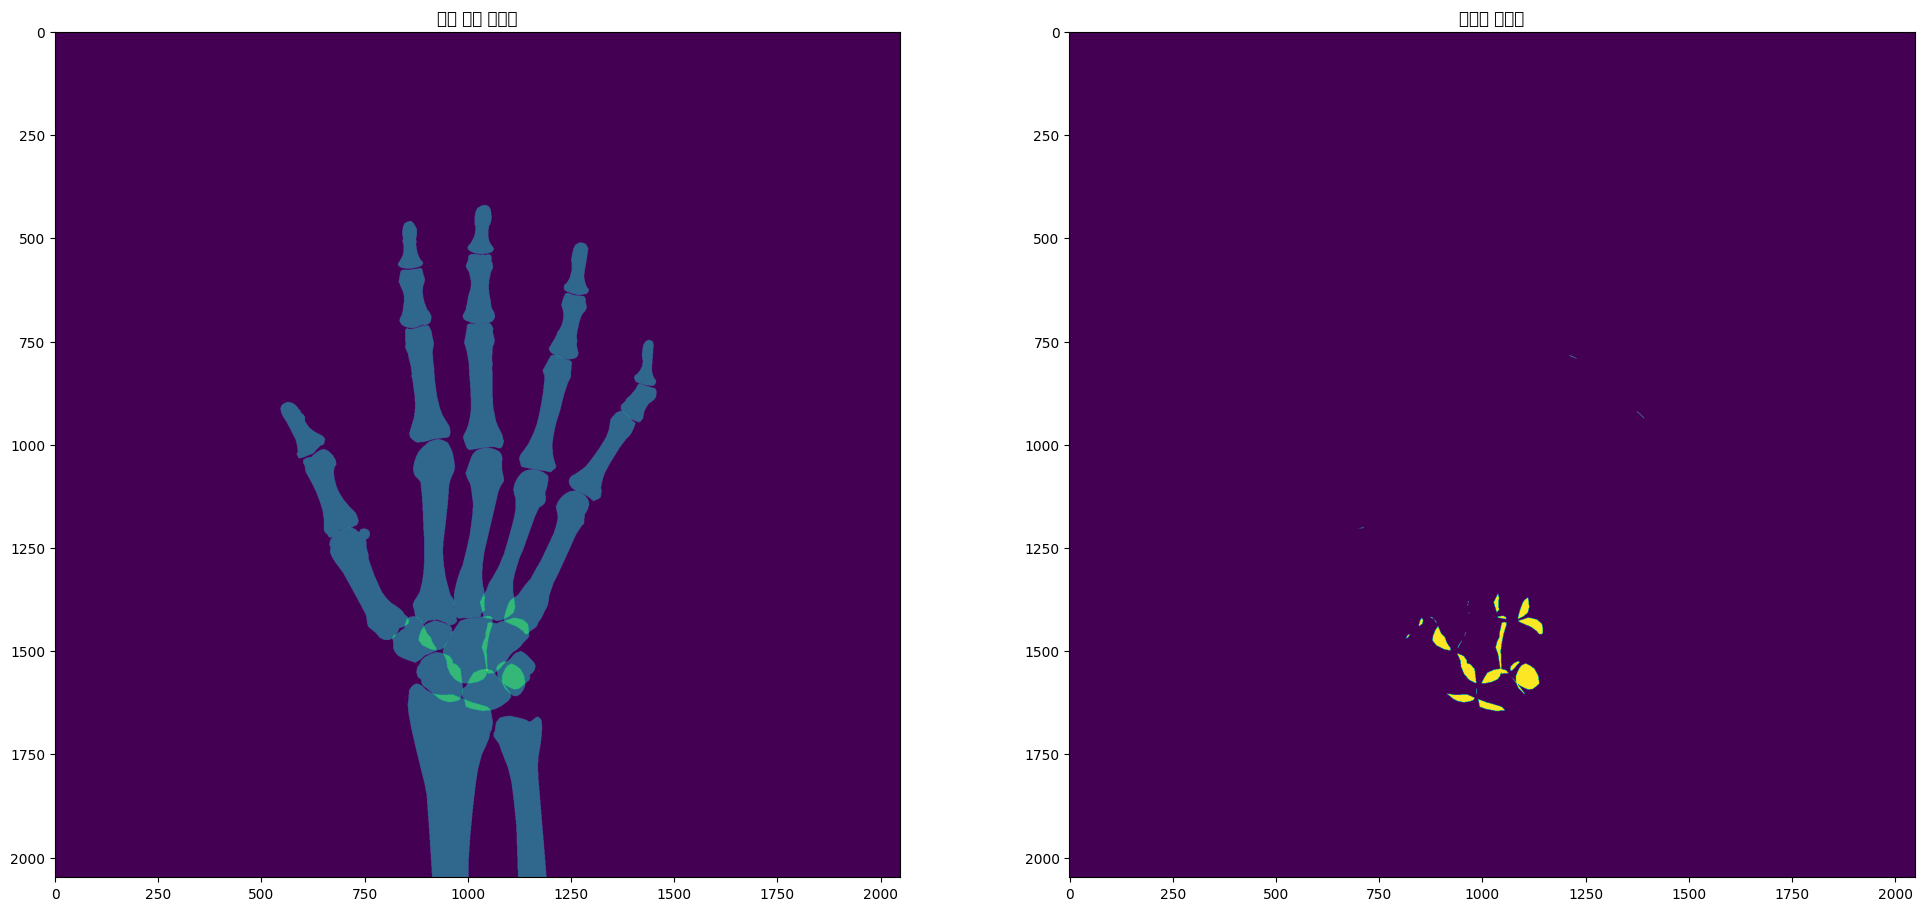

(2048, 2048, 29)
최대로 겹친 구간 수 :  3.0
(2048, 2048)


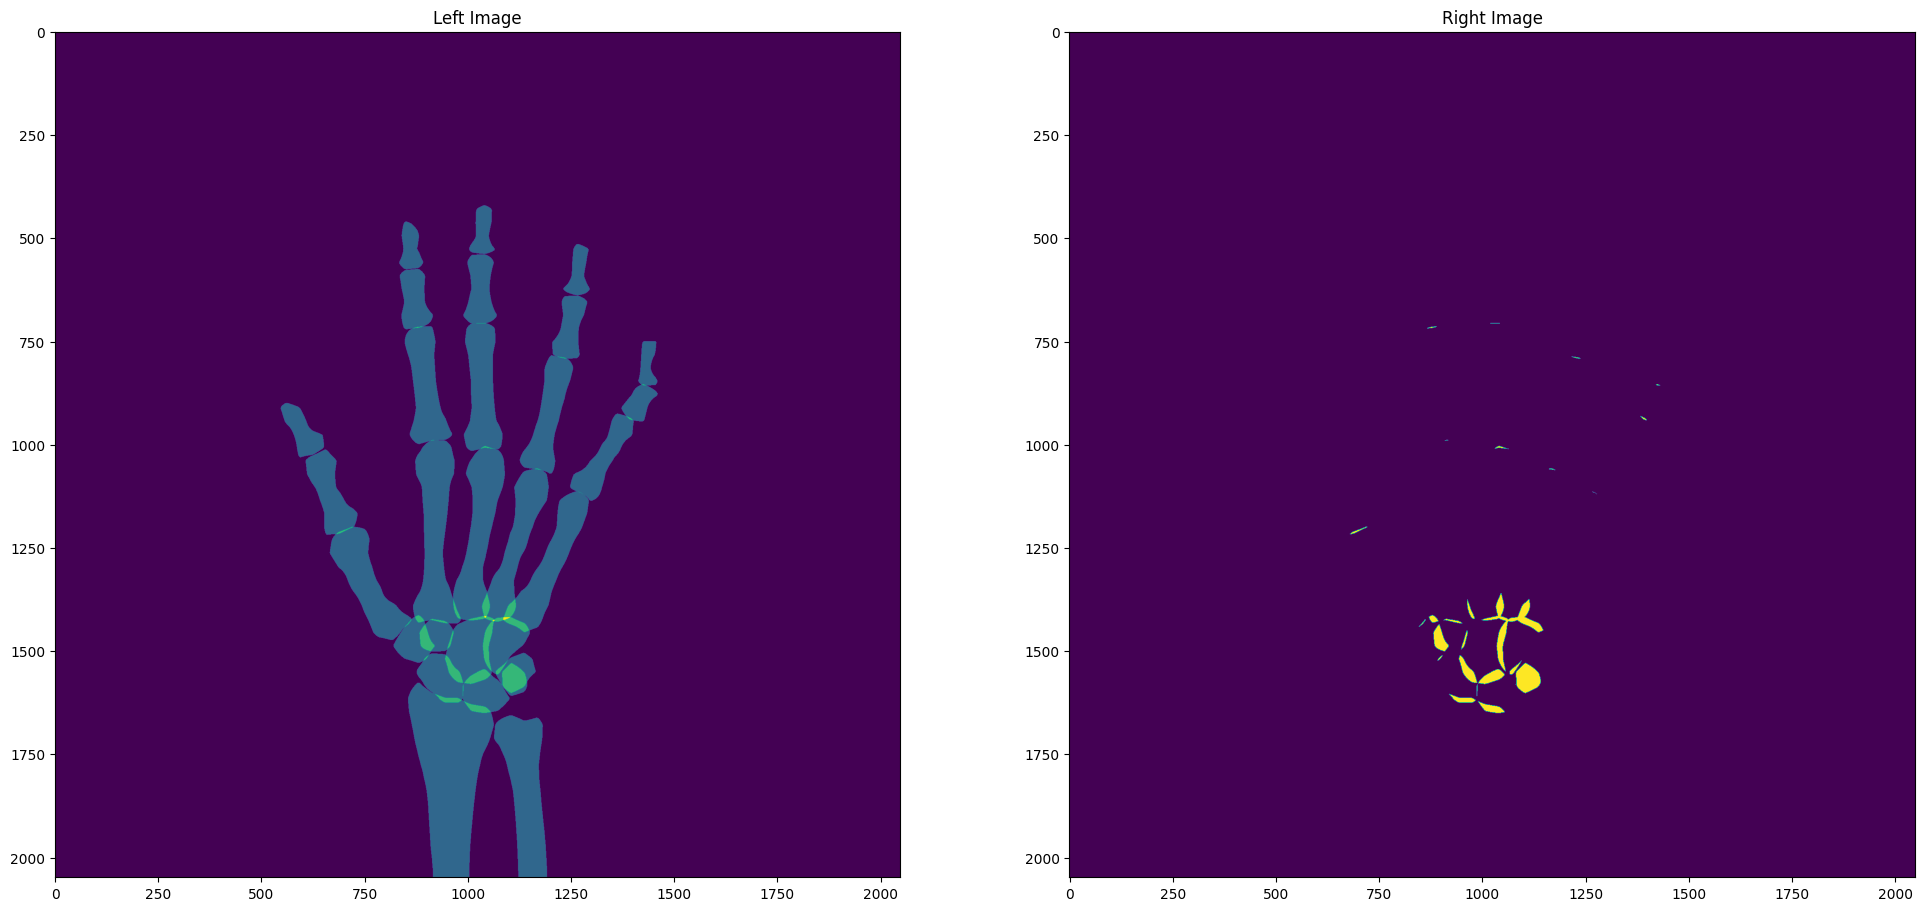

In [123]:
# image, label = valid_dataset[193]
input = label.numpy()
input = np.transpose(input,(1,2,0)) # 1038, 1920, 3

result = np.zeros((input.shape[0],input.shape[1]))


for i in range(29):
    # plt.imshow(input[:,:,i])
    # plt.show()
    result += input[:,:,i]
    
fig, ax = plt.subplots(1,2,figsize=(24, 12))
# plt.imshow(result)
ax[0].imshow(result)
ax[0].set_title('라벨 정답 이미지')



aa = list(result.flatten())
print('최대로 겹친 구간 수 : ',max(aa))

# print over 1
res = result.copy() # 전체 가져와서 1을 더해줌.
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        if res[i,j] > 1:
            res[i,j] = 1
        else:
            res[i,j] = 0

print(res.shape)
# plt.imshow(res)

# Plotting the right image
ax[1].imshow(res)
ax[1].set_title('겹치는 이미지')


# Adjusting the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()


# image, label = valid_dataset[193]
# outputs = output.detach().cpu().numpy()
# outputs = output.detach().cpu().numpy()
outputs = output[0]
outputs = np.transpose(outputs,(1,2,0)) # 1038, 1920, 3
print(outputs.shape)


result = np.zeros((outputs.shape[0],outputs.shape[1])) # 다시 0으로 초기화


for i in range(29):
    # plt.imshow(outputs[:,:,i])
    # plt.show()
    result += outputs[:,:,i]

# result를 보여준다. 근데 값이 정수가 아니게 되어있음 이거 제대로 고쳐야될까?
    
fig, ax = plt.subplots(1,2,figsize=(24, 12))
# plt.imshow(result)
ax[0].imshow(result)
ax[0].set_title('Left Image')



aa = list(result.flatten())
print('최대로 겹친 구간 수 : ',max(aa))

# print over 1
res2 = result.copy() # 1과 0으로 표시된 것.
for i in range(res2.shape[0]):
    for j in range(res2.shape[1]):
        if res2[i,j] > 1:
            res2[i,j] = 1
        else:
            res2[i,j] = 0

print(res2.shape)
# plt.imshow(res)

# Plotting the right image
ax[1].imshow(res2)
ax[1].set_title('Right Image')


# Adjusting the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()




In [104]:
False+True

1

In [134]:
input.shape,outputs.shape

((2048, 2048, 29), (2048, 2048, 29))

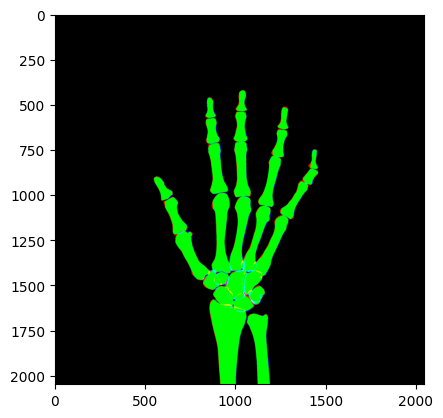

In [107]:


f1 = np.zeros((input.shape[0],input.shape[1],3))
# bgr

# plt.imshow(result2)  검정 화면나옴.

for i in range(29):
    # plt.imshow(input[:,:,i])
    # plt.show()
    for k in range(2048):
        for l in range(2048):
            if input[k,l,i]==1 and outputs[k,l,i]==1:
                f1[k,l,1]=1 # green
            elif input[k,l,i]==1 and outputs[k,l,i]==0:
                f1[k,l,0]=1 # flase positive blue
            elif input[k,l,i]==0 and outputs[k,l,i]==1:
                f1[k,l,2]=1 # flase negative red

plt.imshow(f1)
    



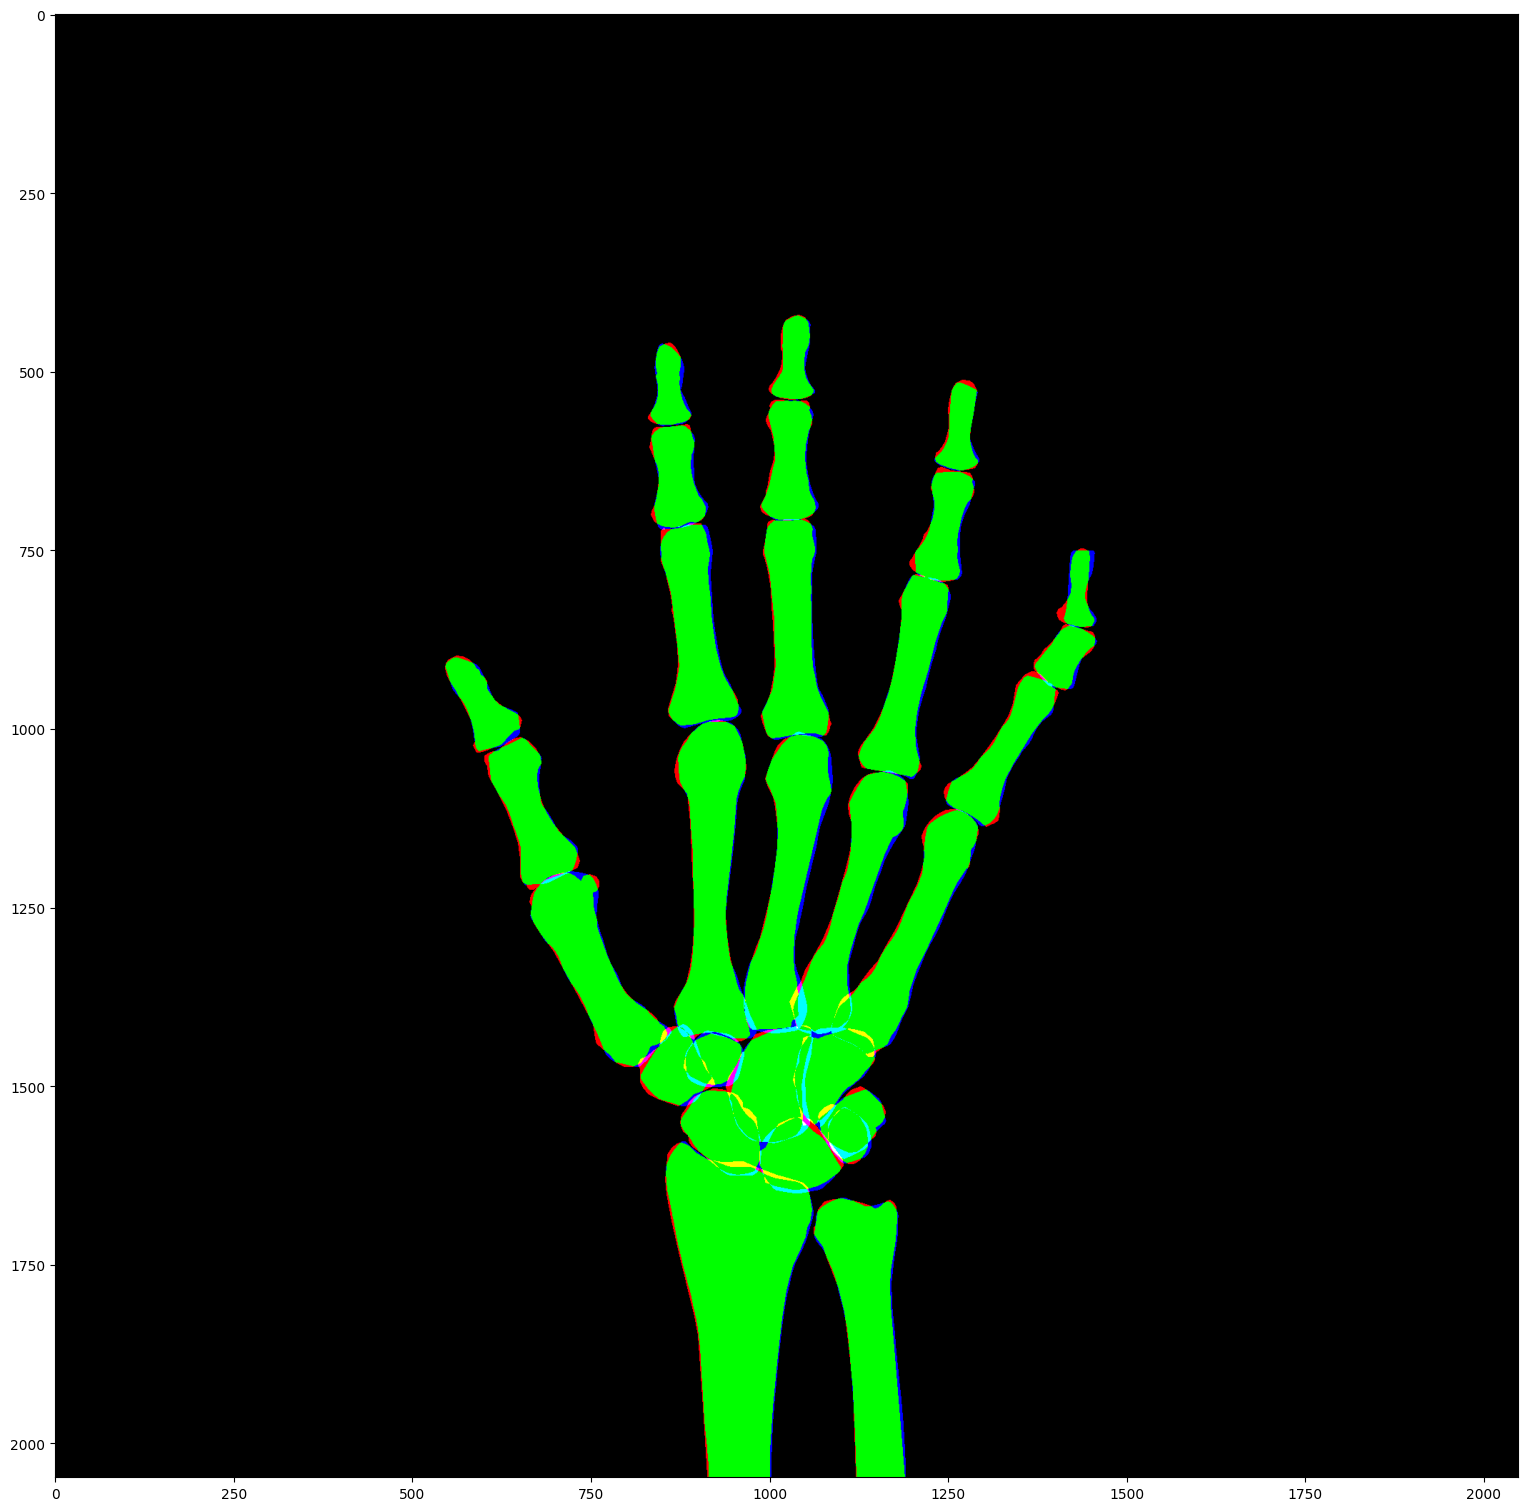

In [133]:
fig = plt.figure(figsize=(19,19))
plt.imshow(f1)

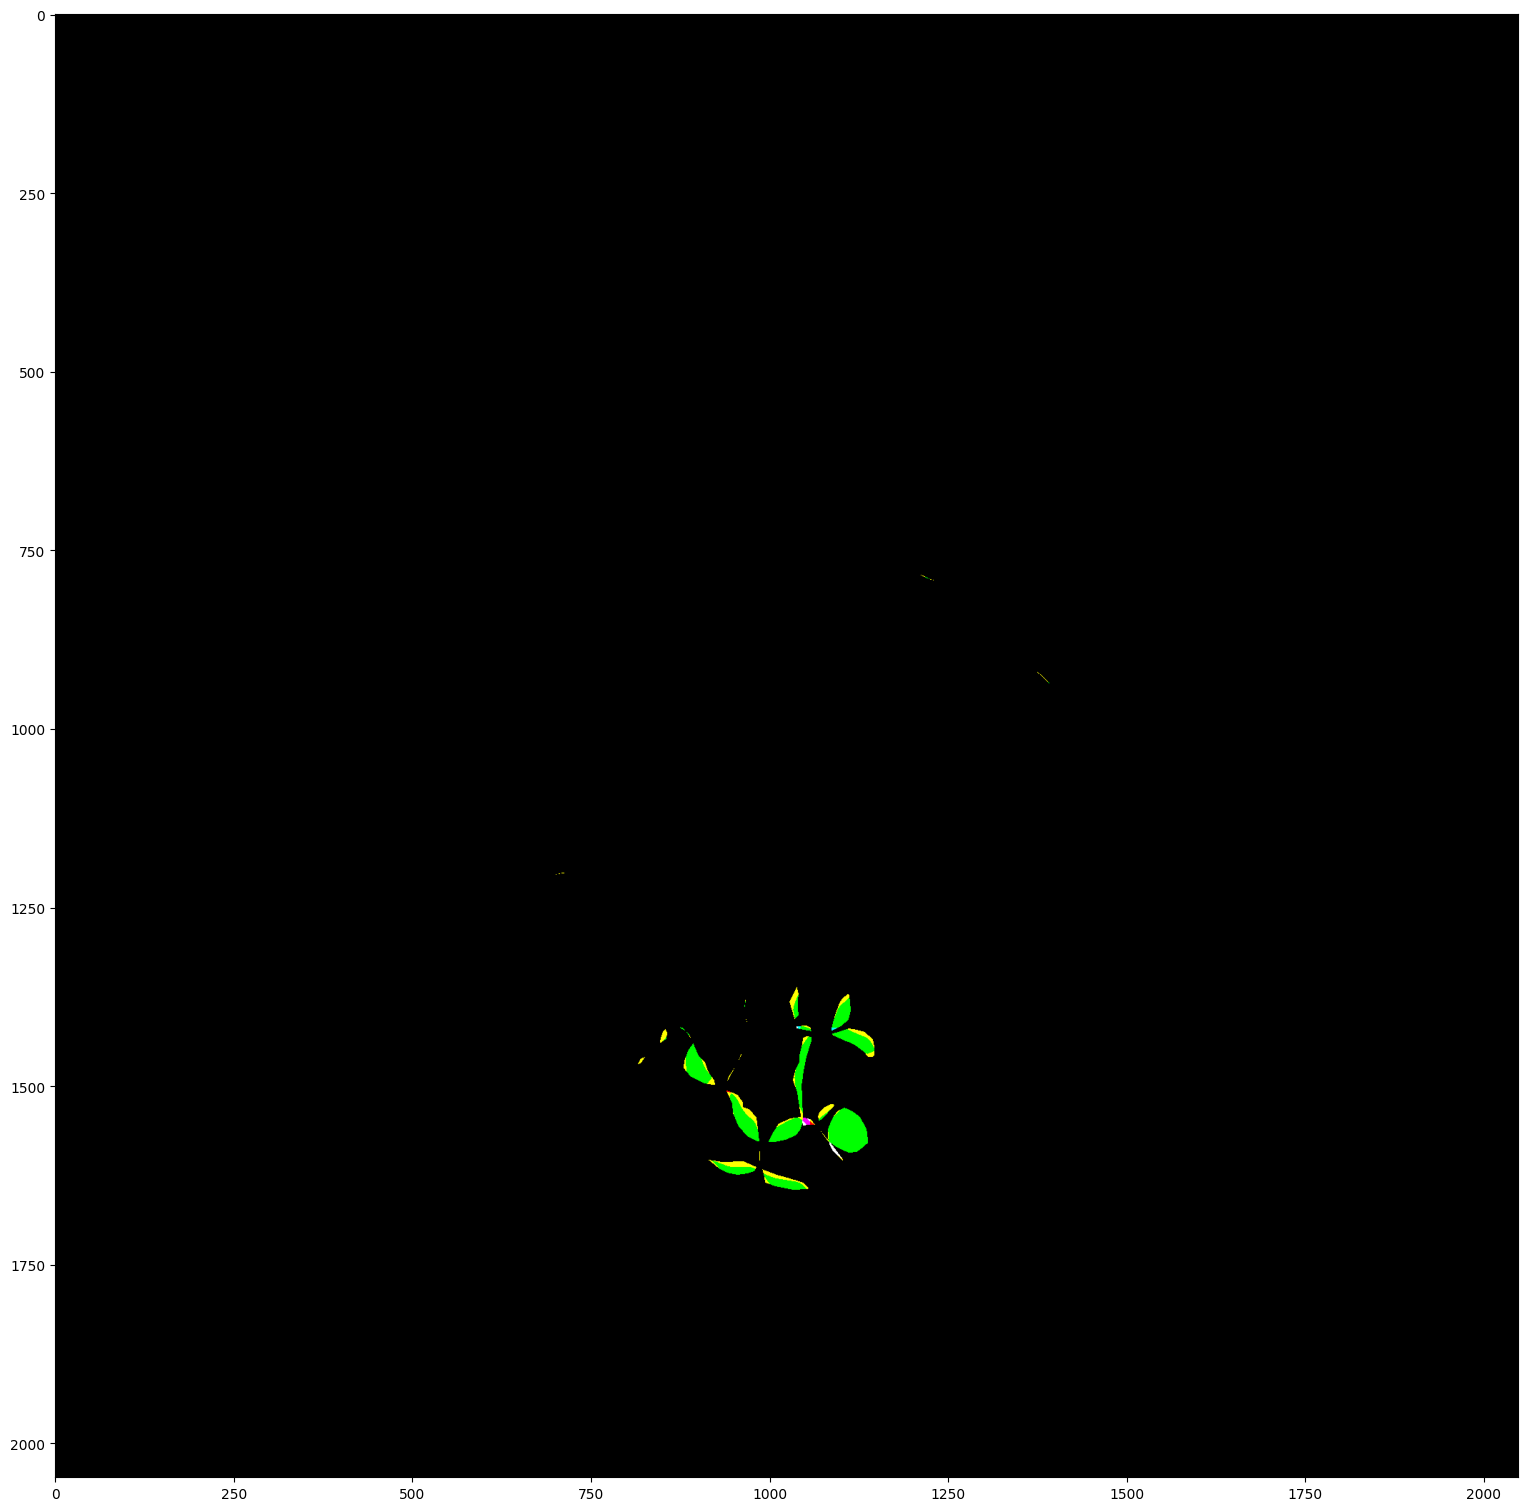

In [125]:
res_3ch = np.array([res,res,res])
res_3ch = np.transpose(res_3ch,(1,2,0))
# outputs = np.transpose(outputs,(1,2,0)) # 1038, 1920, 3
f1_res = np.multiply(f1,res_3ch)

fig = plt.figure(figsize=(19,19))


plt.imshow(f1_res)

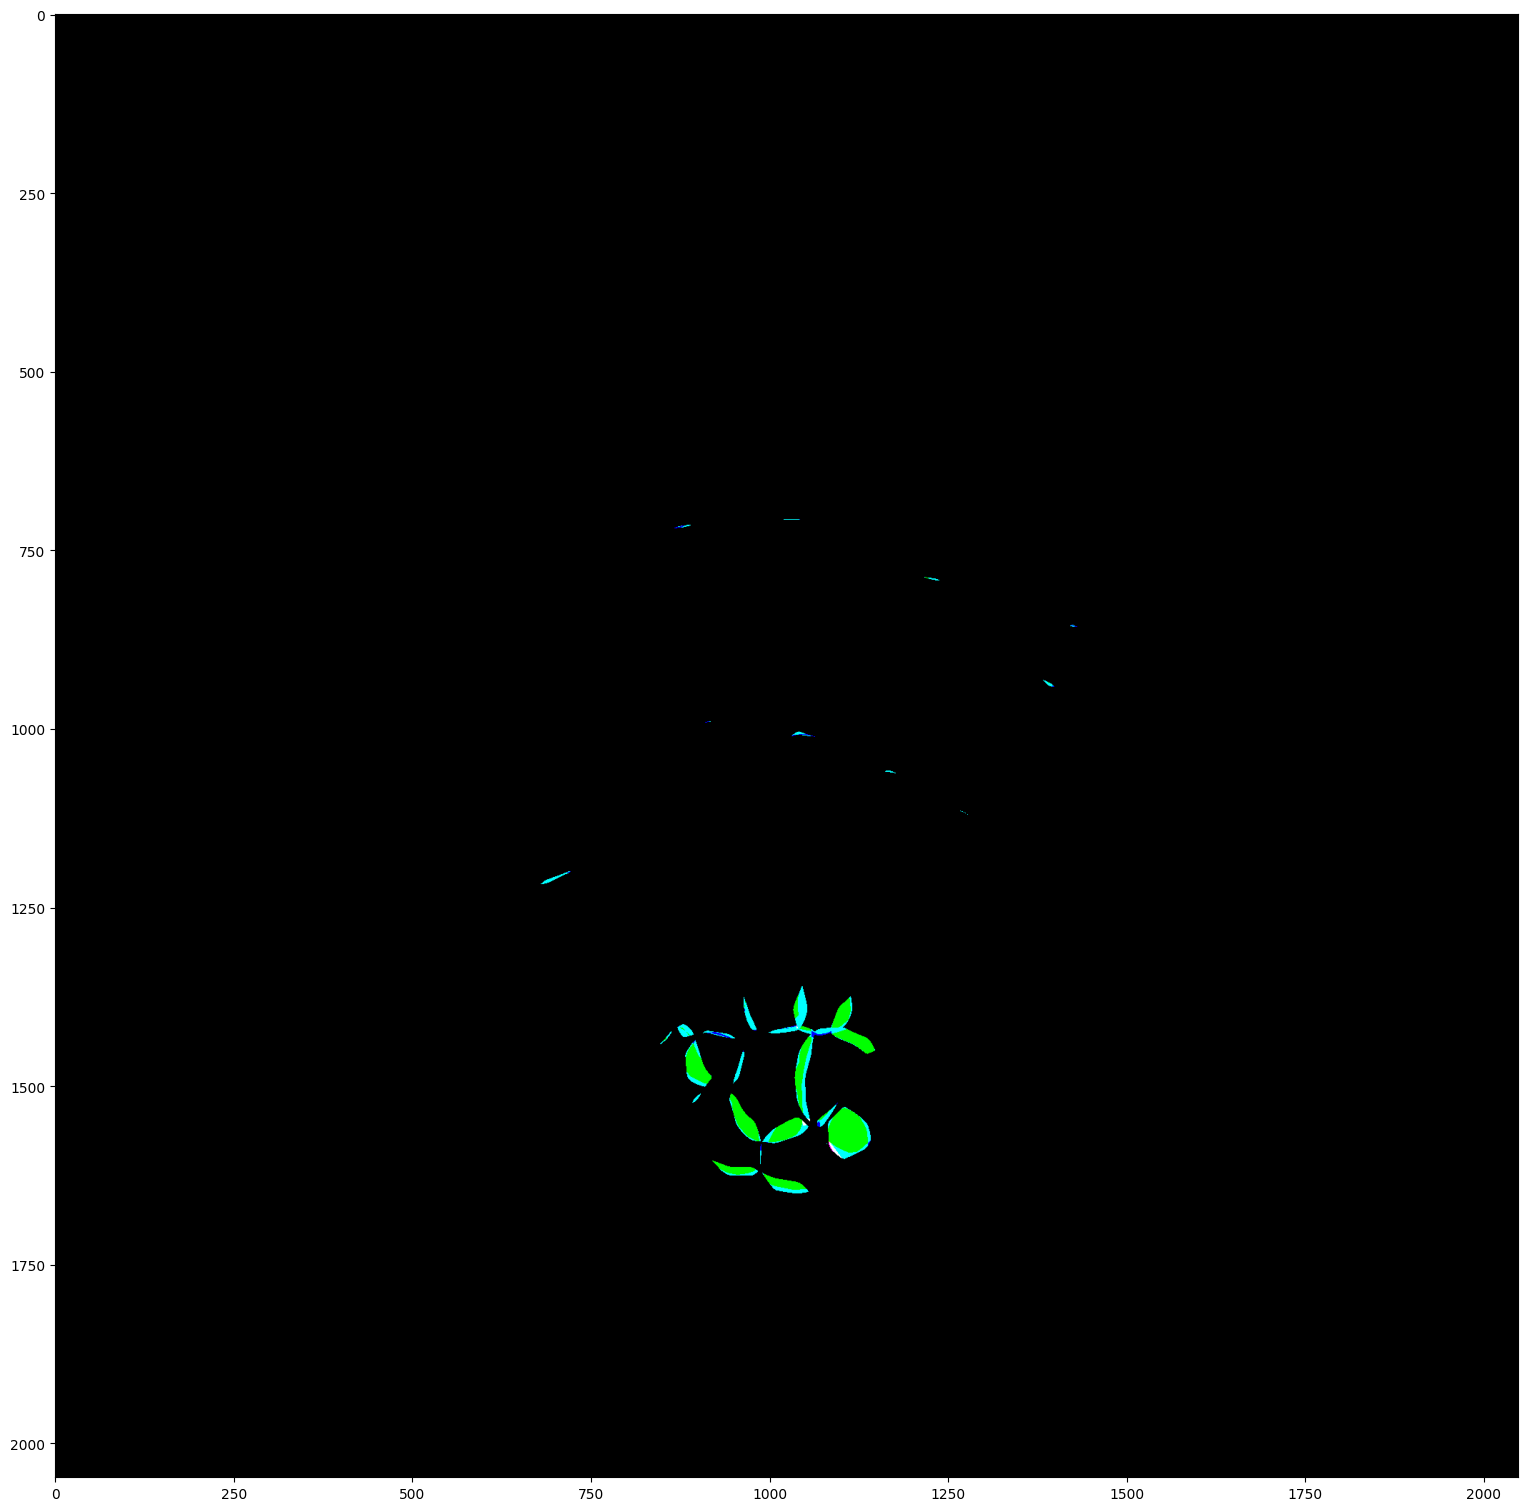

In [126]:
res2_3ch = np.array([res2,res2,res2])
res2_3ch = np.transpose(res2_3ch,(1,2,0))
# outputs = np.transpose(outputs,(1,2,0)) # 1038, 1920, 3
f1_res2 = np.multiply(f1,res2_3ch)
fig = plt.figure(figsize=(19,19))
plt.imshow(f1_res2)

In [ ]:
# image, label = valid_dataset[193]
input = label.numpy()
input = np.transpose(input,(1,2,0)) # 1038, 1920, 3

result = np.zeros((input.shape[0],input.shape[1]))



result = np.zeros((outputs.shape[0],outputs.shape[1]))


for i in range(29):
    # plt.imshow(outputs[:,:,i])
    # plt.show()
    result += outputs[:,:,i]

for i in range(29):
    # plt.imshow(input[:,:,i])
    # plt.show()
    result += input[:,:,i]
    
fig, ax = plt.subplots(1,2,figsize=(24, 12))
# plt.imshow(result)
ax[0].imshow(result)
ax[0].set_title('Left Image')



aa = list(result.flatten())
print('최대로 겹친 구간 수 : ',max(aa))

# print over 1
res = result.copy()
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        if res[i,j] > 1:
            res[i,j] = 1
        else:
            res[i,j] = 0

print(res.shape)
# plt.imshow(res)

# Plotting the right image
ax[1].imshow(res)
ax[1].set_title('Right Image')


# Adjusting the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()



In [ ]:
# i = 5

# preds = []
# for rle in rles[i*29:(i+1)*29]:
#     pred = decode_rle_to_mask(rle, height=2048, width=2048)
#     preds.append(pred)
# preds = np.stack(preds, 0)

# v_image, label = valid_dataset[i]
# image = cv2.imread(os.path.join(IMAGE_ROOT, filenames[i]))

# fig, ax = plt.subplots(1, 4, figsize=(28, 7))

# ax[0].imshow(image)    # remove channel dimension
# ax[1].imshow(label2rgb(preds))
# ax[2].imshow(v_image[0])
# ax[3].imshow(label2rgb(label))
# plt.show()

NameError: name 'rles' is not defined

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.8/asy

: 